Can classification algorithms correctly predict a 1st baseman vs a shortstop in baseball.  The shortstop position is one of the most demanding positions in baseball regarding agility and coordination.  First base is one of the "hot boxes" of baseball.  At 90 feet, the reaction time of 1st baseman needs to be second to no other player other than maybe 3rd base.

The following are the results of trying to classify a 1st baseman vs. a shortstop using the following features:

                        height - height of player
                        weight - weight of player
                        H - number of hits of player for each year
                        2B - number of yearly doubles
                        3B - number of yearly triples
                        HR - number of yearly home runs
                        OPS - yearly On Base Plus Slugging
                        OBP - yearly On Base Percentage
                        SLG - yearly slugging
                        SF - yearly sacrifice flies
                        BB - number of  walks

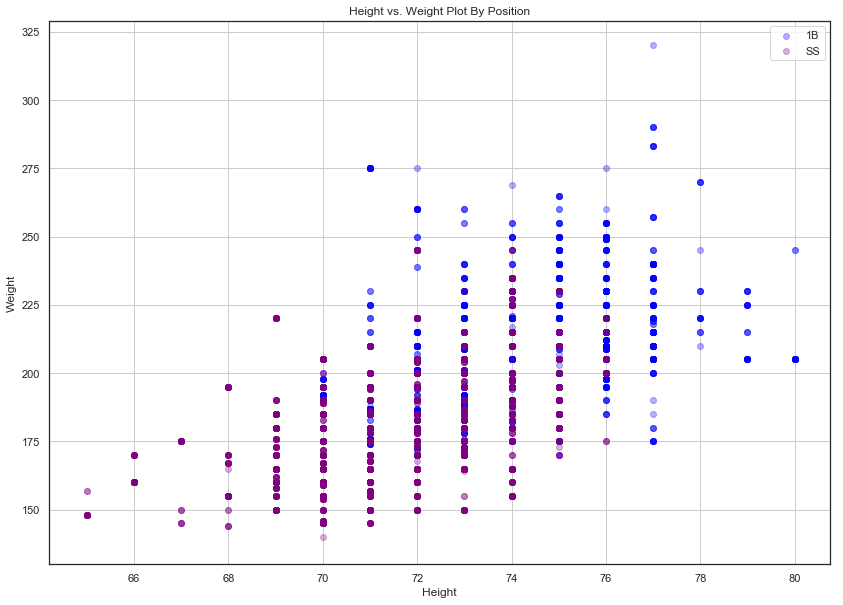

playerlen hold back 443


XGB Classifier - Baseball


Accuracy Score: 0.8352
Confusion Maxtrix: 
[[161  42]
 [ 31 209]]
Classification Report: 
              precision    recall  f1-score   support

       False       0.84      0.79      0.82       203
        True       0.83      0.87      0.85       240

   micro avg       0.84      0.84      0.84       443
   macro avg       0.84      0.83      0.83       443
weighted avg       0.84      0.84      0.83       443



Knn Classifier - Baseball


Accuracy Score: 0.7449
Confusion Maxtrix: 
[[154  49]
 [ 64 176]]
Classification Report: 
              precision    recall  f1-score   support

       False       0.71      0.76      0.73       203
        True       0.78      0.73      0.76       240

   micro avg       0.74      0.74      0.74       443
   macro avg       0.74      0.75      0.74       443
weighted avg       0.75      0.74      0.75       443



RF Classifier - Baseball


Accuracy Score: 0.8217
Confusion Maxtrix: 
[[157  46]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.4s finished


{'C': 10, 'gamma': 0.001}
0.6947368421052632
Accuracy Score: 0.7246
Confusion Maxtrix: 
[[132  71]
 [ 51 189]]
Classification Report: 
              precision    recall  f1-score   support

       False       0.72      0.65      0.68       203
        True       0.73      0.79      0.76       240

   micro avg       0.72      0.72      0.72       443
   macro avg       0.72      0.72      0.72       443
weighted avg       0.72      0.72      0.72       443



Naive Bayes Classifier - Baseball


Accuracy Score: 0.6637
Confusion Maxtrix: 
[[188  15]
 [134 106]]
Classification Report: 
              precision    recall  f1-score   support

       False       0.58      0.93      0.72       203
        True       0.88      0.44      0.59       240

   micro avg       0.66      0.66      0.66       443
   macro avg       0.73      0.68      0.65       443
weighted avg       0.74      0.66      0.65       443



LR Classifier - Baseball


Accuracy Score: 0.8036
Confusion Maxtrix: 
[[159  44]


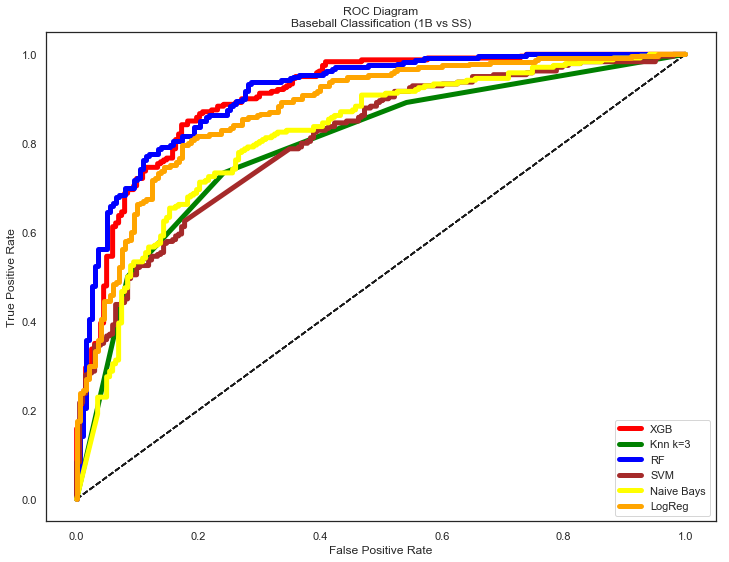

True

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  7 14:30:24 2019

@author: Paul Scheibal
"""
#
#  This program tries to predict if a player is a first baseman or shortstop
#  given a feature list
#
import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import matplotlib.mlab as mlab
import math
from numpy.random import seed
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import seaborn as sns; sns.set(color_codes=True)
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white') 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

figsize(14,10)

fig, ax = plt.subplots()
ax.grid()
# calculate BMI index
def calc_BMI(df,h,w):
    meters = df[h] * 0.0254
    kilograms = df[w] * 0.453582
    BMI = kilograms / (meters ** 2)
    df['BMI'] = round(BMI,2)
    return df
# custom split train/test
def split_players(df,pct):
    seed(61)
    players = np.array(df.playerID.drop_duplicates())
    plen = len(players)
    indlst = random.sample(range(0,plen), round(pct*plen))
    print('playerlen hold back ' + str(round(plen*pct)))
    test_players = np.array(players[indlst])
    train_players = np.setdiff1d(players,test_players)
    return train_players, test_players
# custom split train/test
def split_df(df,pct):
    dfx = df[['playerID','G','AB','H','2B','3B','HR','SF','BB','HBP']].groupby('playerID').sum().reset_index()
    dfx = calc_ops(dfx)
    dfy = df[['playerID','POS','weight','height']].groupby('playerID').first().reset_index()
    df = pd.merge(dfx,dfy,on='playerID')
    train_p, test_p = split_players(df,pct)
    df_train = df[df.playerID.isin(train_p)]
    df_test = df[df.playerID.isin(test_p)]
    return df_train, df_test
# standard OPS calculation function
def calc_ops(df):    
    df['1B'] = df['H'] - ( df['2B'] + df['3B'] + df['HR'] )  
    df['TB'] =  df['1B'] + (df['2B'] * 2) + (df['3B'] * 3) + (df['HR'] * 4)                             
    df['SLG'] = df['TB'] / df['AB']
    df['OBP_OB'] = ( df['H'] + df['BB'] + df['HBP'] )
    df['OBP_PA'] = ( df['AB'] + df['BB'] + df['SF'] + df['HBP'] )   
    df['OBP'] = df['OBP_OB'] / df['OBP_PA'] 
    df['OPS'] = df['OBP'] + df['SLG'] 
    df['AVG'] = df['H'] / df['AB']
    return  df
# classifation metrics
def classification_metrics(X_test, y_test, y_pred, classifier,clr,lbl, roctitle,showflag):
    print('Accuracy Score: %1.4f' % accuracy_score(y_pred,y_test))
    print('Confusion Maxtrix: ')
    print(confusion_matrix(y_test,y_pred))
    print('Classification Report: ')
    print(classification_report(y_test,y_pred))
    
    y_pred_prob = classifier.predict_proba(X_test)[:,1]
    fpr, tpr, thesholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, linewidth=5,color=clr,label=lbl)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(roctitle)
    if showflag == True:
        leg = plt.legend(loc='lower right')
        plt.show()
    return True

figsize(12,9)

########################################## Baseball Fun ###############################################

MIN_AT_BATS = 0
START_YEAR = 1954
END_YEAR = 2018
FSHZ = 17
START_DATE = datetime.strptime(str(START_YEAR)+'-01-01','%Y-%m-%d')
END_DATE = datetime.strptime(str(END_YEAR)+'-12-31','%Y-%m-%d')
LEGEND_PROPERTIES = {'weight':'bold'}
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'

print('process starting...')

battingf = path + 'dfbatting_player_allstats.csv'
dfbatting_player_stats = pd.read_csv(battingf,parse_dates=['debut','finalGame','birthdate'])

dfbatting_player_stats = dfbatting_player_stats[(dfbatting_player_stats['debut'] >= START_DATE) &
                                                (dfbatting_player_stats['finalGame'] <= END_DATE)]
df = dfbatting_player_stats
df = df[ ( df['OPS'] > 0 ) ]
df = df[df['POS'].isin(['SS','1B'])]

df1b = df[df['POS'] == '1B']
dfss = df[df['POS'] == 'SS']
plt.scatter(df1b['height'], df1b['weight'],color='blue',alpha=0.3,label='1B')
plt.scatter(dfss['height'], dfss['weight'],color='purple',alpha=0.3,label='SS')
plt.title('Height vs. Weight Plot By Position')
plt.xlabel('Height')
plt.ylabel('Weight')
leg = plt.legend()
plt.show()

feature_list =  ['height','weight','H','2B','3B','HR','OPS','OBP','SLG','SF','BB']
pct=.40
df_train, df_test = split_df(df,pct)
X_train = df_train[feature_list]
y_train = (df_train.POS == '1B').values
X_test = df_test[feature_list]
y_test = (df_test.POS == '1B').values

########################################## XGBoost ###############################################

print('\n')
print('XGB Classifier - Baseball')
print('\n')
xgb_cls = XGBClassifier()
xgb_cls.fit(X_train,y_train)
y_pred = xgb_cls.predict(X_test)
classification_metrics(X_test, y_test, y_pred, xgb_cls,'red','XGB', 'XGBoost ROC Curve\nBaseball Classification (1B vs SS)',False)

########################################## Knn 3 ##################################################

print('\n')
print('Knn Classifier - Baseball')
print('\n')
k=3
knn_cls = KNeighborsClassifier(n_neighbors=k)
knn_cls.fit(X_train,y_train)
y_pred = knn_cls.predict(X_test)
classification_metrics(X_test, y_test, y_pred, knn_cls,'green','Knn k='+str(k), 'Knn ROC Curve\nBaseball Classification (1B vs SS)',False)

########################################## Random Forest ##################################################

print('\n')
print('RF Classifier - Baseball')
print('\n')
rf_cls = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

rf_cls.fit(X_train,y_train)
y_pred = rf_cls.predict(X_test)
classification_metrics(X_test, y_test, y_pred, rf_cls,'blue','RF','Random Forests ROC Curve\nBaseball Classification (1B vs SS)',False)


########################################## SVM Classifier ################################################

print('\n')
print('SVM Classifier - Baseball')
print('\n')
params = {
        'C': [0.1,1,10],
        'gamma':[0.001,0.01,0.1]
        }
svm_cls = SVC(probability=True)
gs = GridSearchCV(estimator=svm_cls, 
                  param_grid=params, 
                  cv=3,
                  n_jobs=-1, 
                  verbose=2
                 )
gs.fit(X_train,y_train)
y_pred = gs.predict(X_test)
print(gs.best_params_)
print(gs.best_score_)
classification_metrics(X_test, y_test, y_pred, gs,'brown','SVM','SVM ROC Curve\nBaseball Classification (1B vs SS)',False)

########################################## NB Classifier ################################################

print('\n')
print('Naive Bayes Classifier - Baseball')
print('\n')
#nb_cls = GaussianNB()
nb_cls = MultinomialNB(alpha=0.001)
nb_cls.fit(X_train,y_train)
y_pred = nb_cls.predict(X_test)
classification_metrics(X_test, y_test, y_pred, nb_cls,'yellow','Naive Bays', 'Naive Bayes ROC Curve\nBaseball Classification',False)

########################################## LR Classifier ################################################

print('\n')
print('LR Classifier - Baseball')
print('\n')
lr_cls = LogisticRegression()
lr_cls.fit(X_train,y_train)
y_pred = lr_cls.predict(X_test)
classification_metrics(X_test, y_test, y_pred, lr_cls,'orange','LogReg', 'ROC Diagram\nBaseball Classification (1B vs SS)',True)


And the winner is... XGB and Random Forest Classifiers!